In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras as tfk

from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras import backend as K


from utils import preprocess_time_series_v2

Using TensorFlow backend.


In [2]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')


In [3]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')

X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series_v2(df, date_init='2016', date_final='2017', date_val='2018', date_test='2019', 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

/home/blasting/TFG_TimeSeries/notebooks/utils.py:131: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val_data = df[date_val].to_numpy()
/home/blasting/TFG_TimeSeries/notebooks/utils.py:132: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test_data = df[date_test].to_numpy()
                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-2

In [4]:
X_val.shape

(8659, 96, 1)

In [5]:
y_val.shape

(8659, 6)

In [6]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [7]:

n_neurons_per_layer = int(2/3*(X_train.shape[1]*X_train.shape[2]))

inputs = tfk.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
time2vec = T2V(128)(inputs)
flatten_outputs = tfk.layers.Flatten()(time2vec)
dnn_output = tfk.layers.Dense(n_neurons_per_layer, activation='relu')(flatten_outputs)
dnn_output = tfk.layers.Dense(n_neurons_per_layer,
activation='relu')(dnn_output)

outputs = tfk.layers.Dense(y_train.shape[1], activation='linear')(dnn_output)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer= tfk.optimizers.Adam(),
metrics=[tfk.metrics.MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 1)]           0         
_________________________________________________________________
t2v (T2V)                    (None, 96, 129)           12608     
_________________________________________________________________
flatten (Flatten)            (None, 12384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                792640    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 809,798
Trainable params: 809,798
Non-trainable params: 0
_______________________________________________________

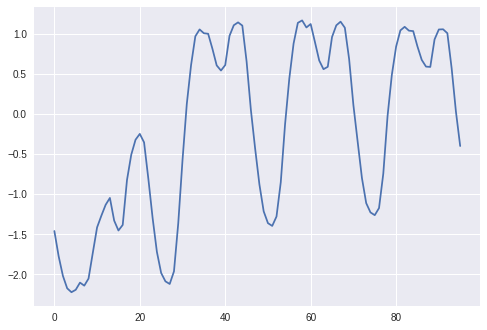

In [8]:
plt.plot(X_val[0])

In [10]:
batch_size = 256
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=50, 
                    validation_data=(X_val, y_val)) 



Epoch 1/50
68/68 [==============================] - 5s 63ms/step - loss: 0.3751 - mean_absolute_error: 0.4540 - val_loss: 0.0802 - val_mean_absolute_error: 0.1956
Epoch 2/50
68/68 [==============================] - 4s 53ms/step - loss: 0.0694 - mean_absolute_error: 0.1819 - val_loss: 0.0449 - val_mean_absolute_error: 0.1475
Epoch 3/50
68/68 [==============================] - 4s 55ms/step - loss: 0.0435 - mean_absolute_error: 0.1454 - val_loss: 0.0372 - val_mean_absolute_error: 0.1377
Epoch 4/50
68/68 [==============================] - 4s 54ms/step - loss: 0.0365 - mean_absolute_error: 0.1327 - val_loss: 0.0326 - val_mean_absolute_error: 0.1267
Epoch 5/50
68/68 [==============================] - 4s 55ms/step - loss: 0.0331 - mean_absolute_error: 0.1262 - val_loss: 0.0303 - val_mean_absolute_error: 0.1186
Epoch 6/50
68/68 [==============================] - 4s 53ms/step - loss: 0.0279 - mean_absolute_error: 0.1152 - val_loss: 0.0285 - val_mean_absolute_error: 0.1192
Epoch 7/50
68/68 [====

In [10]:
np.save( 'arrays_guardados/densetime2vec_train',              history.history['loss'])
np.save( 'arrays_guardados/densetime2vec_val',
    history.history['val_loss'])

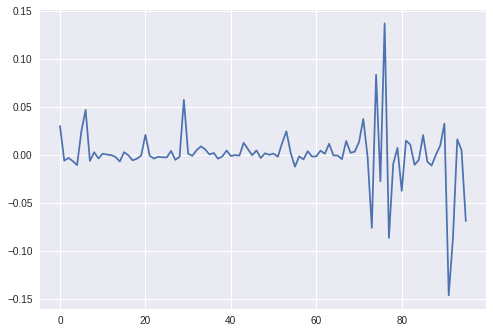

In [41]:
cw1 = np.array(model.layers[1].get_weights())
plt.plot(cw1[2]*X_val[0] + cw1[3])
#plt.plot(X_val[0])

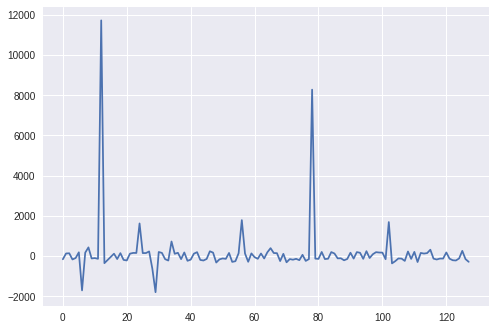

In [91]:
plt.plot((2*np.pi)/cw1[0][0])

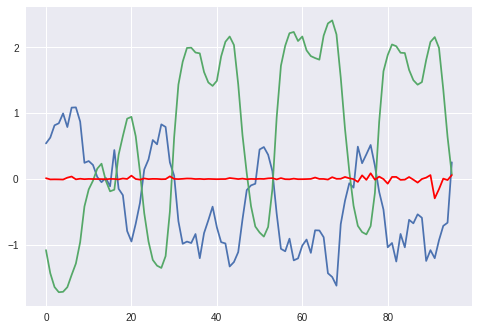

In [61]:
"""plt.plot(np.sum(np.sin(np.dot(X_val[0], cw1[0]) + cw1[1]), axis=0))"""
for val_data in X_val[144:145]:
    plt.plot(np.sum(np.sin(np.dot(val_data, cw1[0]) + cw1[1]), axis=1))
    plt.plot(val_data, label="Entrada de validación")
    plt.plot(cw1[2]*val_data + cw1[3], color='red')

In [1]:
loss

NameError: name 'loss' is not defined

In [11]:
def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform(yhat)


In [12]:
y_hat = model.predict(X_test)
y_hat_2 = model.predict(X_val)

y_test, y_hat = inverse_transform(y_hat, y_test, scaler)
y_val, y_hat_2 = inverse_transform(y_hat_2, y_val, scaler)

In [13]:
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts(test, forecasts, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = mean_absolute_error(actual, predicted)
		print('t+%d MSE: %f' % ((i+1), rmse))

In [14]:
print("test")
evaluate_forecasts(y_test, y_hat, 6)

print("validacion")
evaluate_forecasts(y_val, y_hat_2, 6)

test
t+1 MSE: 231.659744
t+2 MSE: 300.695518
t+3 MSE: 343.235823
t+4 MSE: 390.596100
t+5 MSE: 438.678372
t+6 MSE: 474.417098
validacion
t+1 MSE: 228.953447
t+2 MSE: 307.170297
t+3 MSE: 354.941744
t+4 MSE: 394.041445
t+5 MSE: 446.809496
t+6 MSE: 481.965107


In [2]:
(231.659744 + 300.695518 + 343.235823 + 390.596100 + 438.678372 + 474.417098) / 6

363.21377583333333

In [15]:
y_hat.shape

(8587, 6)

(144,)
(144,)


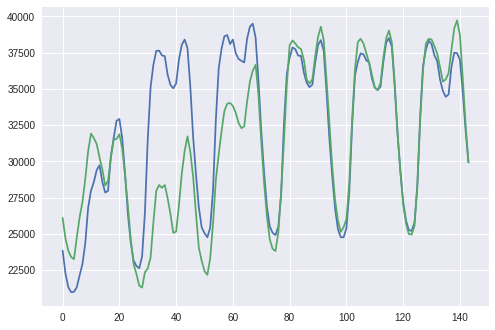

In [16]:
# plot the entire dataset in blue

test_size = 144
real_data = scaler.inverse_transform(X_val[test_size:2*test_size, 0, 0])
print(real_data.shape)
forecastings = y_hat[:test_size, 0]
print(forecastings.shape)
plt.plot(real_data)
plt.plot(forecastings)
# plot the forecasts in red
#for i in range(len(forecastings)):
    #xaxis = np.arange(i, forecastings.shape[1]+i)
    #if xaxis[-1] > real_data.shape[0]-1:
    #    continue
    #plt.plot(xaxis, forecastings[i], color='red')
# show the plot
#plt.show()

In [17]:
real_data

array([23841., 22269., 21323., 20971., 20999., 21314., 22146., 22929.,
       24383., 26815., 27977., 28572., 29393., 29731., 28578., 27848.,
       27958., 30341., 31618., 32799., 32925., 31610., 29168., 26356.,
       24427., 23172., 22780., 22626., 23430., 26460., 31523., 35124.,
       36679., 37620., 37639., 37309., 37252., 35979., 35269., 35034.,
       35379., 37043., 38040., 38401., 37819., 35142., 31674., 29070.,
       26829., 25450., 25043., 24761., 25422., 28003., 32879., 36410.,
       37770., 38625., 38711., 38093., 38400., 37456., 37066., 36931.,
       36822., 38461., 39293., 39498., 38542., 35599., 32093., 29220.,
       26864., 25497., 25070., 24913., 25480., 27743., 32598., 36032.,
       37139., 37858., 37738., 37294., 37274., 36123., 35423., 35116.,
       35294., 36802., 38032., 38361., 37622., 34797., 31570., 28999.,
       26762., 25332., 24766., 24755., 25373., 27845., 32411., 35904.,
       36848., 37446., 37383., 36978., 36811., 35707., 35078., 34921.,
      

In [25]:
forecastings

array([[23212.117, 25945.465, 28041.676, 29132.498, 29989.922, 30328.25 ],
       [26277.502, 28086.117, 29349.984, 30073.361, 30561.217, 30809.89 ],
       [29400.484, 30376.55 , 30981.691, 31198.648, 31574.787, 31616.453],
       ...,
       [27741.371, 27844.195, 27507.217, 26406.424, 25654.86 , 25659.986],
       [27286.21 , 26843.74 , 26262.05 , 25154.06 , 25195.504, 26641.361],
       [26985.578, 25947.916, 25098.5  , 25421.86 , 26543.797, 28172.568]],
      dtype=float32)